In [191]:
# %load_ext autoreload
%autoreload 1

import random
import simpy
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

%aimport model

### Задание (выполнять в отдельном .py и .ipynb файлах)

Реализовать дополнительно следующую логику:

1. Сделать модель ограниченной по времени, а не по количеству клиентов. Клиентов сделать с двумя разными типами задач (отношение $3:1$). Задача первого типа с параметром $time\_in\_bank=9.0$, второго - $time\_in\_bank=15.0$.
2. Количество окон обслуживания сделать параметром модели. Приоритетов и выталкивания в модели нет.
3. Ввести экономическую функцию: за каждого обслуженного клиента с задачей первого типа прибыль $3$, второго типа - $6$, за потерянного клиента первого типа издержки $1.1$, второго типа - $2.5$, фиксированные издержки за сотрудников составляют $0.03$ в единицу времени на человека, а также бонус за задачу первого типа $0.3$, второго типа - $0.5$.

Максимизировать чистую прибыль по параметру числа окон на горизонте 5000 временых шагов.

# Model

Модель с 1-3 реализованными 1-3 п. в `model.py`

In [234]:
env = simpy.Environment()
simulation = model.Bank(env, num_windows=2, max_time=40, print_logs=True)
res = simulation.run_until_time()

 0.0000 Customer0: Here I am
 0.0000 Customer0: Waited  0.000
 0.1453 Customer0: Finished
10.9104 Customer1: Here I am
10.9104 Customer1: Waited  0.000
15.2003 Customer2: Here I am
15.2003 Customer2: Waited  0.000
15.2908 Customer1: Finished
15.9979 Customer3: Here I am
15.9979 Customer3: Waited  0.000
21.0942 Customer4: Here I am
22.4691 Customer4: RENEGED after  1.375
23.9552 Customer3: Finished
24.4399 Customer5: Here I am
24.4399 Customer5: Waited  0.000
28.8359 Customer6: Here I am
30.1157 Customer6: RENEGED after  1.280
32.9340 Customer7: Here I am
33.4333 Customer2: Finished
33.4333 Customer7: Waited  0.499
36.0982 Customer7: Finished
39.4712 Customer5: Finished


In [235]:
res

17.200000000000003

# Optimize



Банк - организация чаще всего довольно консервативная

В них используется много схем для расчета рисков и ожидаемой прибыли, но тк я, признаться честно, ~~из класса коррекции~~ несильно в них шарю, попробуем просто смотреть на нижнюю границу доверительного интервала для матожидания прибыли при каждом кол-ве окон 

В таком случае можем +/- гарантировать, что при не самом лучше сценарии мы будем более менее зарабатывать

p. s. 

на клиентов, которые в очереди на момент остановки, забиваем. Оно конечно все больший эффект будет давать с ростом кол-ва окон, но мы при таком кол-ве окон, где это реально будет на что-то влиять, кажется будут проблемы посерьезнее неучтенных последних клиентов

In [236]:
def confidence_interval(arr, confidence_lvl=0.95):
    mean = np.mean(arr)
    std_error = stats.sem(arr)
    margin_of_error = std_error * stats.t.ppf((1 + confidence_lvl) / 2, len(arr) - 1)
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    return (lower_bound, upper_bound)

In [237]:
confidence_interval([1, 1, 2, 1, 1, 2, 4, 1, 1, 1])

(0.8047980489575298, 2.19520195104247)

In [238]:
ITERS = 200
CONF_LVL = 0.9

metrics = []
windows = list(range(1, 15))

data = []

In [239]:
for wn in tqdm(windows):

    array = [0]*ITERS
    for i in range(ITERS):
        env = simpy.Environment()
        simulation = model.Bank(env, num_windows=wn, max_time=5000, print_logs=False)
        array[i] = simulation.run_until_time()

    metrics.append(
        confidence_interval(
            array, CONF_LVL
        )
    )
    data.append(array)

100%|███████████████████████████████████████████| 14/14 [00:27<00:00,  1.98s/it]


In [240]:
list(zip(windows, metrics))[:5]

[(1, (408.44627802620283, 421.15672197379723)),
 (2, (975.4476422486309, 990.201357751369)),
 (3, (1129.046504431985, 1145.2044955680146)),
 (4, (1061.5983076882762, 1079.4126923117237)),
 (5, (941.0741095633745, 959.4628904366256))]

In [241]:
print(f"Оптимальное кол-во окон с точки зрения {CONF_LVL * 100}\% ДИ прибыли: \
{windows[np.argmax([i[0] for i in metrics])]}")

Оптимальное кол-во окон с точки зрения 90.0\% ДИ прибыли: 3


Ну кажется 3 окна лучше всего


In [231]:
# plt.hist(data[2]);

ДИ кстати не пересекаются (на глаз), сейчас проверим на всякий случай

In [242]:
def find_overlapping_intervals(intervals):  
    overlapping_intervals = []  
    for i in range(len(intervals)):  
        for j in range(i+1, len(intervals)):  
            if intervals[i][1] >= intervals[j][0] and intervals[i][0] <= intervals[j][1]:  
                overlapping_intervals.append((intervals[i], intervals[j]))  
    return overlapping_intervals  

In [243]:
find_overlapping_intervals([[1, 2], [1, 1.1], [7, 16]])

[([1, 2], [1, 1.1])]

In [244]:
find_overlapping_intervals(metrics)

[]

Ну да, тут как будто иначе сравнивать большого смысла и нет, **3 окна побеждают**

(после 3 окон к тому же наглядная и в целом объяснимая убывающая траектория, поэтому большее кол-во окон рассматривать кажется не требуется)

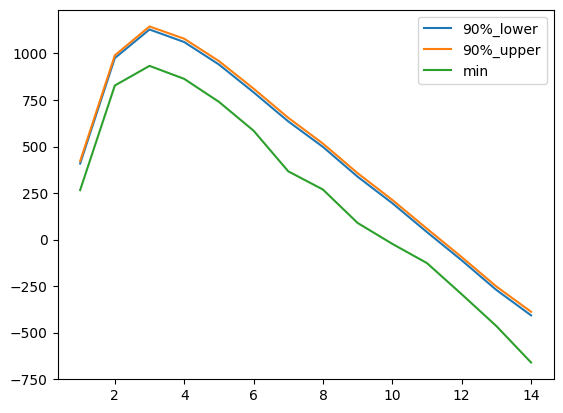

In [245]:
plt.plot(
    windows, metrics, label=['90%_lower', '90%_upper']
);
plt.plot(
    windows, [min(i) for i in data], label='min'
)
plt.legend();

**по традиции, добрый мем в конце работы:**

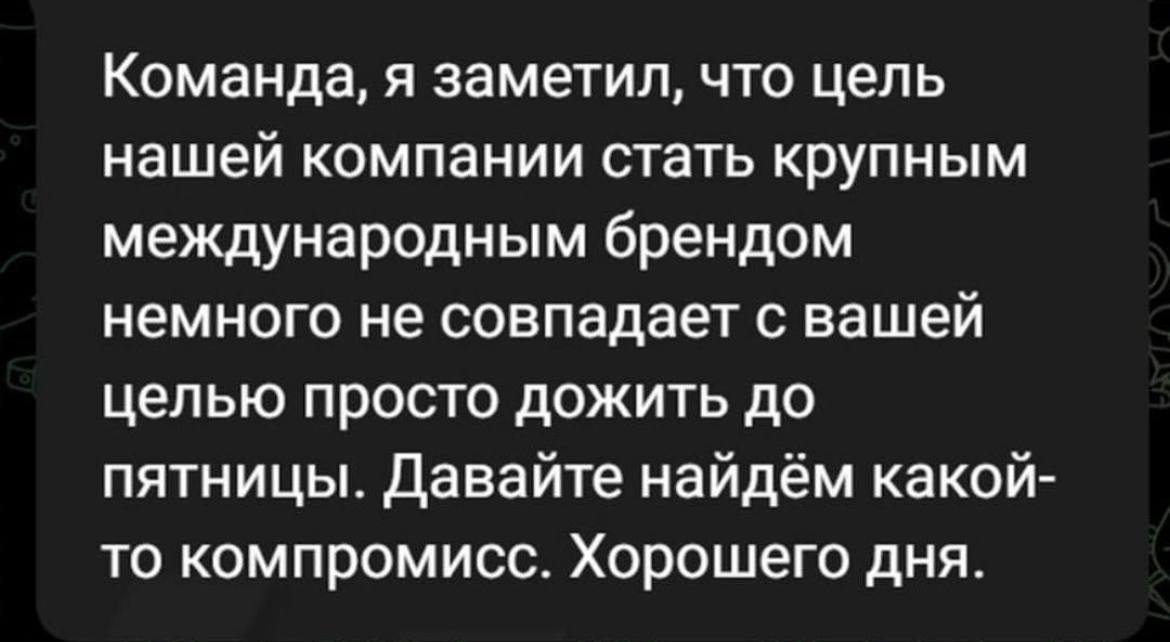